Import Required Libraries.

In [2411]:
import numpy as np
from PIL import Image
from pathlib import Path
from matplotlib import pyplot as plt

Load Images and Labels.

In [2412]:
images = []
labels = []
for dir in Path("att_faces").iterdir():
    dir_name = dir.name
    try: # There is a hidden '.DS_Store' dir apparently, so to avoid errors relating to that.
        dir_index = int(dir_name[1:]) # Getting the label.
    except ValueError:
        continue
    for img in Path(f"att_faces/{dir.name}").iterdir():
        labels.append(dir_index) # Storing labels.
        image = Image.open(img)
        images.append(np.array(image).flatten()) # Storing images.

face_images = np.array(images).T # Transposing to make it such that the images are in columns.
face_labels = np.array(labels)

num_face_images = face_images.shape[1]
num_labels = len(np.unique(face_labels))
#print(num_face_images, num_labels)


# Getting some non-face images for recognition/clasification.
non_face_paths = []
for img in Path("non_faces").iterdir():
    non_face_paths.append(img)

non_face_paths = np.array(non_face_paths)
non_face_img = [] 
for img in non_face_paths:
    image = Image.open(img)
    image = image.convert('L') # Converting to grayscale.
    image = image.resize((112, 92)) # Resizing to 112 x 92.
    non_face_img.append(np.array(image).flatten())

non_face_img = np.array(non_face_img).T

Mean Center the data.

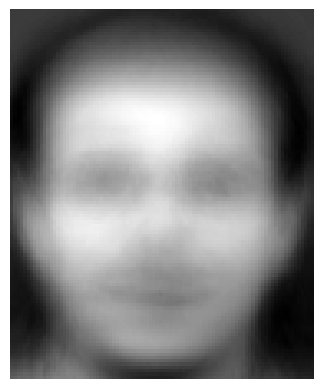

In [2413]:
mean = np.mean(face_images, axis = 1, keepdims = True) # Dimension means. 
face_images_centered = face_images - mean 

# Visualizing the "mean" face.
plt.imshow(mean.reshape((112, 92)), cmap = 'gray')
plt.axis('off')
plt.show()

Getting the orthogonal eigenvectors of X @ X_T (where X is the mean centered data) via SVD of X. The left singular vectors of X are (by definition) the orthogonal eigenvectors of X @ X_T and the square of the singular values are the eigenvalues of X @ X_T.

In [2414]:
# full_matrices = False only gives > 0 eigenvalues and their corresponding eigenvectors.
# Our image matrix may not have full rank, that is, there could be some dimensions that 
# are linear combinations of others. We get rid of those as they are redundant. 
eigvecs, singvals, _ = np.linalg.svd(face_images_centered, full_matrices = False)
# Note: in SVD, the singular values are the square root of the eigenvalues of X @ X_T. Thus squaring. 
# And the actual covariance formula is: (1/(n-1)) * (P_T @ X @ X_T @ P), thus the division by (n-1) .
eigvals = singvals ** 2 / (num_face_images - 1)  

Visualizing (the most important 10) eigenfaces.

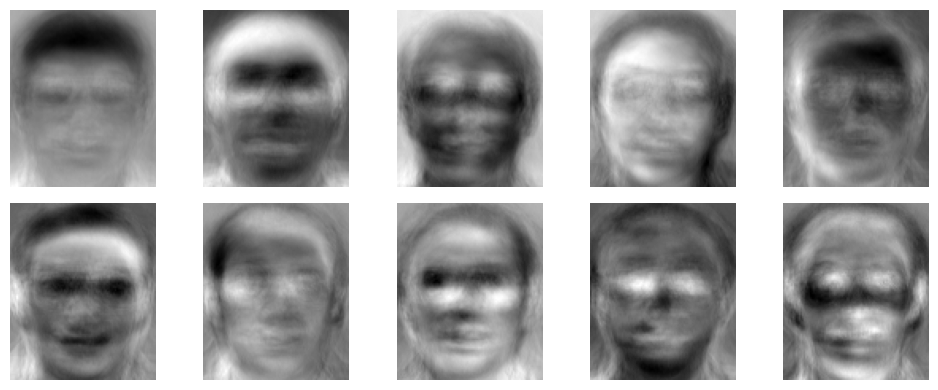

In [2415]:
imp_faces = []
for i in range(0, 10):
    imp_faces.append(eigvecs[:, i].reshape((112, 92)))

imp_faces = np.array(imp_faces)

fig, axarr = plt.subplots(2, 5, figsize = (10, 4))
axarr_flat = axarr.flatten()

for i, img in enumerate(imp_faces):
    axarr_flat[i].imshow(img, cmap = 'gray')
    axarr_flat[i].axis('off')

plt.tight_layout()
plt.show()

Cumulative sum of eigenvalues (variances) plot. 

111 is the least number of principal components that explains 90% of the variance.


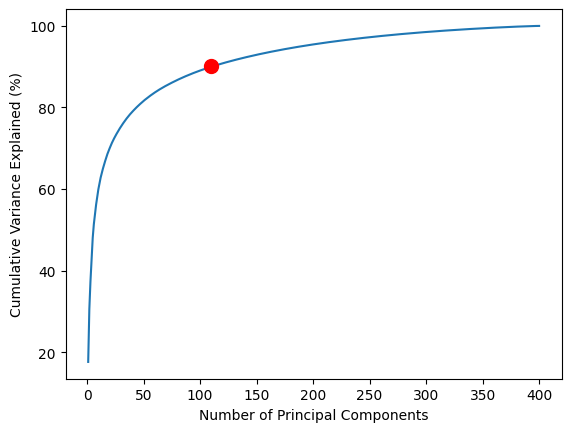

In [2416]:
per = (np.cumsum(eigvals) / np.sum(eigvals)) * 100 # Percentage of variance explained.

num_dim = np.argmax(per >= 90) + 1 # The least number of principal components that explains 90% of the variance.
print(f"{num_dim} is the least number of principal components that explains 90% of the variance.")

plt.plot([i for i in range(1, len(eigvals) + 1)], per)
plt.plot(num_dim - 1, per[num_dim - 1], marker = 'o', markersize = 10, color = 'red')

plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained (%)')

plt.show()

Reconstruction. Note that if you iterate over all possible number of principal components used, the complexity is O(num_pixes^3 * num_data), and num_pixels is like 10000, so this would take forever. 

Error using the first 111 eigenfaces: 153.36350776420616


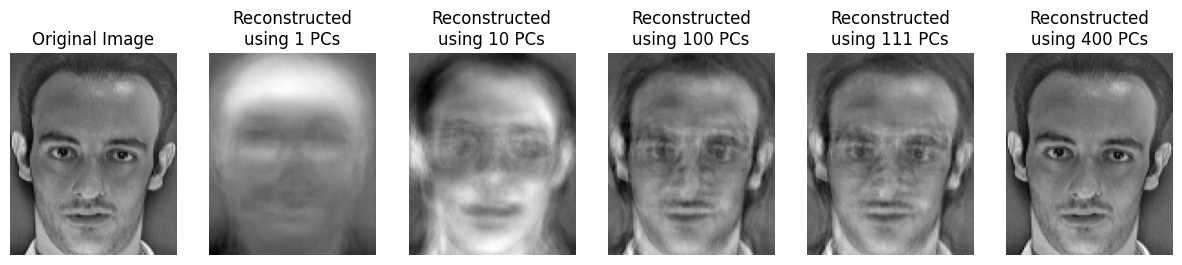

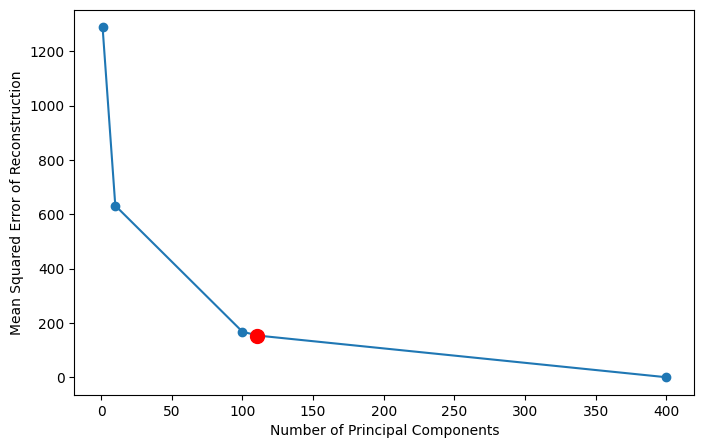

In [2417]:
np.random.seed(7) # For reproducibility.

num_sample = 80
# Picking 80 random images from the dataset.
img_subset = face_images_centered.T[np.random.choice(face_images_centered.shape[1], num_sample, replace = False)].T
pc_grid = [1, 10, 100, num_dim, len(eigvals)] # trying different number of eigenfaces for reconstruction.

# visualizing the reconstruction too for one random image for each case.
random_index = np.random.randint(0, num_sample)
fig, axarr = plt.subplots(1, len(pc_grid) + 1, figsize = (15, 5))
axarr[0].imshow(img_subset[:, random_index].reshape((112, 92)), cmap = 'gray')
axarr[0].set_title("Original Image")
axarr[0].axis('off')
mse_array = []
with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
    for i in pc_grid:
        pc = (eigvecs.T)[0:i, :] # principal components up to i.
        #print(pc)
        rep = pc @ img_subset # representation
        rec = pc.T @ rep # reconstruction

        axarr[pc_grid.index(i) + 1].imshow(rec[:, random_index].reshape((112, 92)), cmap = 'gray')
        axarr[pc_grid.index(i) + 1].set_title(f"Reconstructed\nusing {i} PCs")
        axarr[pc_grid.index(i) + 1].axis('off')

        mse = (np.square(img_subset - rec).mean(axis = 1)).mean() # mse error of reconstruction averaged over number of features
        mse_array.append(mse)


print(f"Error using the first {num_dim} eigenfaces: {mse_array[3]}")

# draw mse vs number of pcs plot
plt.figure(figsize = (8, 5))
plt.plot(pc_grid, mse_array, marker = 'o')
plt.plot(num_dim - 1, mse_array[3], marker = 'o', markersize = 10, color = 'red')

plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Squared Error of Reconstruction")

plt.show()

Train and Test split for both face and non-face images.

In [2418]:
# 70-30 split for random 400 non-face images. We choose 400 because that is the number of total face images.
# We choose 70-30 because that is the split for the face images. Just being consistent.
def random_split_non_face():
    train_images = []
    test_images = []

    random_indices = np.random.choice(non_face_img.shape[1], num_face_images, replace = False)

    for i in random_indices:
        if len(train_images) < int(0.7 * num_face_images):
            train_images.append(non_face_img.T[i])
        else:
            test_images.append(non_face_img.T[i])

    train_images = np.array(train_images).T
    test_images = np.array(test_images).T

    # labels are all 2 for non-face images.
    train_labels = np.array([2.] * train_images.shape[1])
    test_labels = np.array([2.] * test_images.shape[1])

    return train_images, train_labels, test_images, test_labels

def random_split_face(num_subjects, num_data, data, label):
    train_images = []
    train_labels = []
    test_images = []
    test_labels = []

    num_subjects_track = 0
    count = np.zeros(num_labels)

    # for randomization
    random_indices = np.random.permutation(num_face_images)

    # code to divide the images as per instructions into train and test sets. 
    # NOTE: I definitely can write this better, but it works so will bother with it later.
    for i in random_indices:
        if num_subjects_track < num_subjects:
            if count[label[i] - 1] < num_data:
                if count[label[i] - 1] == 0:
                    num_subjects_track += 1
                train_images.append(data.T[i])
                train_labels.append(label[i])
                count[label[i] - 1] += 1
            else:
                test_images.append(data.T[i])
                test_labels.append(label[i])
        else:
            if count[label[i] - 1] > 0 and count[label[i] - 1] < num_data:
                train_images.append(data.T[i])
                train_labels.append(label[i])
                count[label[i] - 1] += 1
            else:
                test_images.append(data.T[i])
                test_labels.append(label[i])

    train_images = np.array(train_images).T
    train_labels = np.array(train_labels)
    test_images = np.array(test_images).T
    test_labels = np.array(test_labels)

    return train_images, train_labels, test_images, test_labels

Linear Discriminant Analysis.

In [2419]:
# Note: The data are appropriately balanced, thus we needn't find accuracy per class. 

def LDA(train_data, train_label, test_data, test_label):
    # divide the train and test data into batches based on their labels.
    # d = dimension of data, n = number of samples.
    d, n = train_data.shape

    class_labels = np.unique(train_label)
    num_classes = len(class_labels)

    class_data = {}
    for label in class_labels:
        class_data[label] = train_data.T[train_label == label].T

    # find prior probabilities for each class.
    priors = {}
    for label in class_labels:
        priors[label] = class_data[label].shape[1] / n

    # find mean of each class.
    class_means = {}
    for label in class_labels:
        class_means[label] = np.mean(class_data[label], axis = 1).reshape((d, 1))

    # mean center each class data.
    class_data_centered = {}
    for label in class_labels:
        class_data_centered[label] = (class_data[label].T - class_means[label].flatten()).T

    # find sigma, which is the shared covariance matrix. That is, the X@X.T of each class summed together
    # and divided by n - num_classes. Note that X is mean centered class data.
    sigma = np.zeros((d, d))
    for label in class_labels:
        sigma += class_data_centered[label] @ class_data_centered[label].T
    sigma /= (n - num_classes)

    with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
        # find the inverse of sigma.
        sigma_inv = np.linalg.pinv(sigma)

    # find log(prior) - 0.5 * mu.T @ sigma_inv @ mu for each class.
    class_constants = {}
    for label in class_labels:
        mu = class_means[label]
        class_constants[label] = np.log(priors[label]) - 0.5 * (mu.T @ sigma_inv @ mu).flatten()[0]

    # classify test data. 
    num_test_samples = test_data.shape[1]
    predictions = []
    for i in range(num_test_samples):
        x = test_data.T[i].reshape((d, 1))
        class_scores = {}
        for label in class_labels:
            mu = class_means[label]
            class_scores[label] = class_constants[label] + (mu.T @ sigma_inv @ x).flatten()[0]
        # predicted label is the one with the maximum score.
        predicted_label = max(class_scores, key = class_scores.get)
        predictions.append(predicted_label)

    predictions = np.array(predictions)
    accuracy = np.sum(predictions == test_label) / num_test_samples
    
    return accuracy

Face Recognition (or detection) using LDA.

In [ ]:
np.random.seed(7)

average_accuracy = 0
accuracies = []
num_trials = 10 

for i in range(num_trials):
    face_train_img, _, face_test_img, _ = random_split_face(35, 8, face_images, face_labels)
    non_face_train_img, non_face_train_labels, non_face_test_img, non_face_test_labels = random_split_non_face()

    train_images = np.concatenate((face_train_img, non_face_train_img), axis = 1)
    train_mean = np.mean(train_images, axis = 1, keepdims = True)

    face_train_centered = face_train_img - train_mean
    non_face_train_centered = non_face_train_img - train_mean
    face_test_centered = face_test_img - train_mean
    non_face_test_centered = non_face_test_img - train_mean

    train_images_centered = np.concatenate((face_train_centered, non_face_train_centered), axis = 1)
    U, S, _ = np.linalg.svd(train_images_centered, full_matrices = False)

    with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
        # representation of face images in the PCA basis.
        face_train_rep = (U.T)[0:3, :] @ face_train_centered
        face_test_rep = (U.T)[0:3, :] @ face_test_centered

        # represenation of non-face images in the PCA basis.
        non_face_train_rep = (U.T)[0:3, :] @ non_face_train_centered
        non_face_test_rep = (U.T)[0:3, :] @ non_face_test_centered

    # basis expansion
    face_train_feat = np.concatenate((face_train_rep, face_train_rep ** 2), axis = 0)
    face_test_feat = np.concatenate((face_test_rep, face_test_rep ** 2), axis = 0)
    non_face_train_feat = np.concatenate((non_face_train_rep, non_face_train_rep ** 2), axis = 0)
    non_face_test_feat = np.concatenate((non_face_test_rep, non_face_test_rep ** 2), axis = 0)

    # labels for face recognition for face images: 1 for face, 2 for non-face.
    face_train_labels = np.array([1.] * face_train_feat.shape[1])
    face_test_labels = np.array([1.] * face_test_feat.shape[1])

    # combining face and non-face images for LDA.
    train_data = np.concatenate((face_train_feat, non_face_train_feat), axis = 1)
    train_labels = np.concatenate((face_train_labels, non_face_train_labels), axis = 0)
    test_data = np.concatenate((face_test_feat, non_face_test_feat), axis = 1)
    test_labels = np.concatenate((face_test_labels, non_face_test_labels), axis = 0)

    # Performing LDA.
    accuracy = LDA(train_data, train_labels, test_data, test_labels)
    accuracies.append(accuracy)
    average_accuracy += accuracy

average_accuracy /= num_trials
print(f"Average accuracy over {num_trials} trials: {average_accuracy}")
print(f"Standard deviation of accuracies: {np.std(accuracies)}")

Average accuracy over 10 trials: 0.9658333333333333
Standard deviation of accuracies: 0.01632993161855452


Face Classification using LDA. 

In [2423]:
np.random.seed(7)

# LDA for classification of face images alone. 
num_trials = 10 
accuracies = []
average_accuracy = 0


for i in range(num_trials):
    face_train_img, face_train_labels, face_test_img, face_test_labels = random_split_face(40, 8, face_images, face_labels)

    train_mean = np.mean(face_train_img, axis = 1, keepdims = True)
    face_train_centered = face_train_img - train_mean
    face_test_centered = face_test_img - train_mean

    U, S, _ = np.linalg.svd(face_train_centered, full_matrices = False)

    with np.errstate(over = 'ignore', divide = 'ignore', invalid = 'ignore'):
        # representation of face images in the PCA basis.
        face_train_rep = (U.T)[0:15, :] @ face_train_centered
        face_test_rep = (U.T)[0:15, :] @ face_test_centered

    # basis expansion
    face_train_feat = np.concatenate((face_train_rep, face_train_rep ** 2), axis = 0)
    face_test_feat = np.concatenate((face_test_rep, face_test_rep ** 2), axis = 0)

    # Performing LDA.
    accuracy = LDA(face_train_feat, face_train_labels, face_test_feat, face_test_labels)
    
    accuracies.append(accuracy)
    average_accuracy += accuracy

average_accuracy /= num_trials
print(f"Average accuracy over {num_trials} trials: {average_accuracy}")
print(f"Standard deviation of accuracies: {np.std(accuracies)}")

Average accuracy over 10 trials: 0.9487499999999999
Standard deviation of accuracies: 0.018915932438026938
